In [ ]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
import numpy as np

from sklearn.model_selection import train_test_split
import torch
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score, f1_score, precision_score
from sklearn.metrics import recall_score, classification_report
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Датасет: https://www.kaggle.com/datasets/ashuthoshdasari/hr-analytics

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ML/экзамен/classification/hr_analytics.csv')
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [ ]:
df.dropna(inplace=True)
df.NumCompaniesWorked = df.NumCompaniesWorked.astype(int)
df.TotalWorkingYears = df.TotalWorkingYears.astype(int)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4382 entries, 0 to 4408
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      4382 non-null   int64 
 1   Attrition                4382 non-null   object
 2   BusinessTravel           4382 non-null   object
 3   Department               4382 non-null   object
 4   DistanceFromHome         4382 non-null   int64 
 5   Education                4382 non-null   int64 
 6   EducationField           4382 non-null   object
 7   EmployeeCount            4382 non-null   int64 
 8   EmployeeID               4382 non-null   int64 
 9   Gender                   4382 non-null   object
 10  JobLevel                 4382 non-null   int64 
 11  JobRole                  4382 non-null   object
 12  MaritalStatus            4382 non-null   object
 13  MonthlyIncome            4382 non-null   int64 
 14  NumCompaniesWorked       4382 non-null  

### Анализ и предобработка

In [ ]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int(np.round((nCol + nGraphPerRow - 1) / nGraphPerRow))
    plt.figure(num = None, figsize = (3 * nGraphPerRow, 4 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

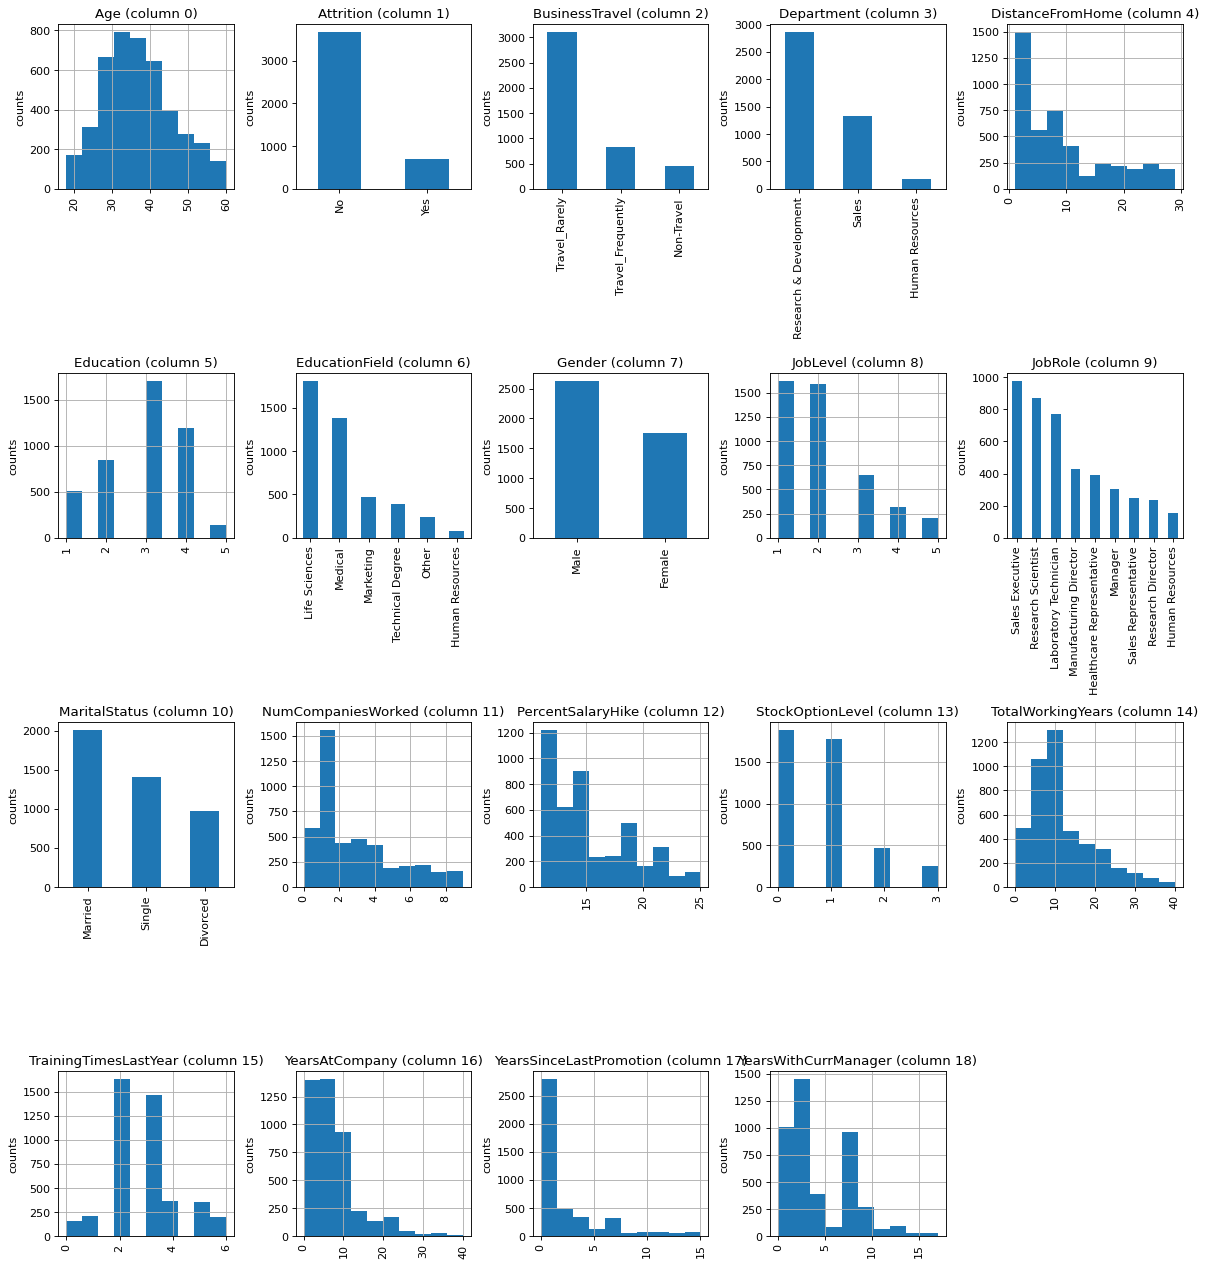

In [ ]:
plotPerColumnDistribution(df, 23, 5)

In [ ]:
def plotCorrelationMatrix(df, graphWidth):
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

df.dropna(inplace=True)
le = LabelEncoder()
df['Attrition'] = le.fit_transform(df['Attrition'])
df['BusinessTravel'] = le.fit_transform(df['BusinessTravel'])
df['Department'] = le.fit_transform(df['Department'])
df['EducationField'] = le.fit_transform(df['EducationField'])
df['Gender'] = le.fit_transform(df['Gender'])
df['JobRole'] = le.fit_transform(df ['JobRole'])
df['MaritalStatus'] = le.fit_transform(df['MaritalStatus'])
df['Over18'] = le.fit_transform(df['Over18'])


numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df.select_dtypes(include=numerics)

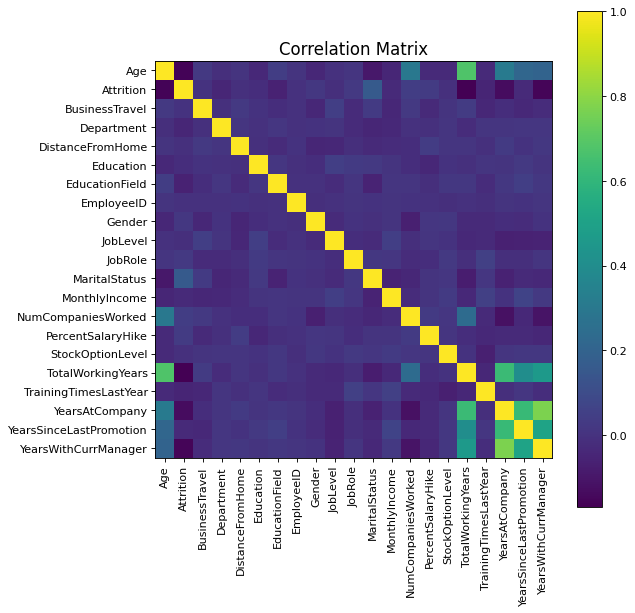

In [ ]:
plotCorrelationMatrix(df, 8)

In [ ]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

In [ ]:
corrs = df.corr()[(df.corr()>=0.5) & (df.corr()<1)]
s = corrs.unstack().dropna()
s.sort_values(ascending=False, kind="quicksort")

YearsAtCompany           YearsWithCurrManager       0.769161
YearsWithCurrManager     YearsAtCompany             0.769161
Age                      TotalWorkingYears          0.680037
TotalWorkingYears        Age                        0.680037
                         YearsAtCompany             0.627738
YearsAtCompany           TotalWorkingYears          0.627738
                         YearsSinceLastPromotion    0.618722
YearsSinceLastPromotion  YearsAtCompany             0.618722
                         YearsWithCurrManager       0.510341
YearsWithCurrManager     YearsSinceLastPromotion    0.510341
dtype: float64

In [ ]:
# df = df.drop(['YearsWithCurrManager', 'Age', 'YearsAtCompany'], axis=1)

In [ ]:
df[['EmployeeCount', 'StandardHours']].describe().loc[['min', 'max']]

,EmployeeCount,StandardHours
min,1.0,8.0
max,1.0,8.0


In [ ]:
df = df.drop(['EmployeeCount', 'StandardHours', 'EmployeeID'], axis=1)
# удаляем бессмысленные для анализа значения

In [ ]:
from sklearn.preprocessing import RobustScaler

robust_scaler = RobustScaler()
for column in df.columns:
    df[column] =robust_scaler.fit_transform(df[column].values.reshape(-1, 1))


In [ ]:
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,1.153846,0.0,0.0,1.0,-0.083333,-0.5,-0.5,-1.0,-0.5,-1.0,...,1.499086,-0.333333,0.0,-0.500000,-1.0,-1.000000,3.0,-0.666667,-0.333333,-0.6
1,-0.384615,1.0,-1.0,0.0,0.250000,-1.0,-0.5,-1.0,-0.5,0.2,...,-0.133504,-0.666667,0.0,1.500000,0.0,-0.444444,0.0,0.000000,0.000000,0.2
2,-0.307692,0.0,-1.0,0.0,0.833333,0.5,1.0,0.0,1.0,0.4,...,2.635150,-0.333333,0.0,0.166667,2.0,-0.555556,-1.0,0.000000,-0.333333,0.0
3,0.153846,0.0,-2.0,0.0,-0.416667,1.0,-0.5,0.0,0.5,-0.8,...,0.622165,0.333333,0.0,-0.500000,2.0,0.333333,2.0,0.500000,2.000000,0.4
4,-0.307692,0.0,0.0,0.0,0.250000,-1.0,0.5,0.0,-0.5,0.4,...,-0.471287,0.666667,0.0,-0.333333,1.0,-0.111111,-1.0,0.166667,-0.333333,0.2


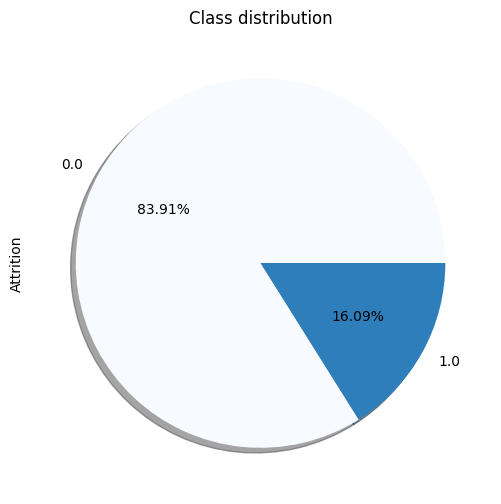

In [ ]:
cmap = plt.get_cmap('Blues')
colors = [cmap(i) for i in np.linspace(0, 0.7, df['Attrition'].unique().shape[0])]

plt.title('Сlass distribution')
df['Attrition'].value_counts().plot(kind='pie', figsize=(6, 6), autopct='%1.2f%%', shadow=True, colors=colors)
plt.show()  # данные очень несбалансированы

### Подготовка датасета

In [ ]:
class Dataset_(Dataset):
  def __init__(self, X, y):
    self.X = X.to_numpy(dtype='float32')
    self.y = y.to_numpy()

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]
    return X, y

In [ ]:
features = df.drop(['Attrition'], axis=1)
target = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size=.5,
                                                    random_state=123,
                                                    stratify=target)

unique, counts = np.unique(y_train, return_counts=True)
class_weights = [1.0/c for c in counts]
sample_weights = [class_weights[int(i)] for i in y_train]

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

In [ ]:
batch_size = 50

train_set = Dataset_(X_train, y_train)
test_set = Dataset_(X_test, y_test)


train_loader = torch.utils.data.DataLoader(train_set,
                                          batch_size=batch_size,
                                          sampler=sampler)
test_loader = torch.utils.data.DataLoader(test_set,
                                         batch_size=batch_size,
                                         shuffle=False)

### Обучение нейронной сети

In [ ]:
features, labels=next(iter(train_loader))

features_num = 20
fc1 = nn.Linear(features_num, 50)
x = torch.tanh(fc1(features))

In [ ]:
import time

def time_since(since):
    now = time.time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
class Net(nn.Module):
    def __init__(self, features_num):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(features_num, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.dropout(self.fc1(x)))
        x = self.relu(self.dropout(self.fc2(x)))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

Epoch:    0/1000 | 0m 0s     | Training loss: 0.693.. | (test) accuracy => 0.74 | (test) f1-score => 0.14
Epoch:  100/1000 | 0m 9s     | Training loss: 0.486.. | (test) accuracy => 0.72 | (test) f1-score => 0.44
Epoch:  200/1000 | 0m 18s    | Training loss: 0.122.. | (test) accuracy => 0.88 | (test) f1-score => 0.68
Epoch:  300/1000 | 0m 27s    | Training loss: 0.015.. | (test) accuracy => 0.94 | (test) f1-score => 0.80
Epoch:  400/1000 | 0m 37s    | Training loss: 0.004.. | (test) accuracy => 0.94 | (test) f1-score => 0.80
Epoch:  500/1000 | 0m 45s    | Training loss: 0.002.. | (test) accuracy => 0.93 | (test) f1-score => 0.79
Epoch:  600/1000 | 0m 55s    | Training loss: 0.001.. | (test) accuracy => 0.93 | (test) f1-score => 0.79
Epoch:  700/1000 | 1m 5s     | Training loss: 0.001.. | (test) accuracy => 0.94 | (test) f1-score => 0.80
Epoch:  800/1000 | 1m 13s    | Training loss: 0.001.. | (test) accuracy => 0.94 | (test) f1-score => 0.80
Epoch:  900/1000 | 1m 24s    | Training loss: 

Text(0.5, 1.0, 'train')

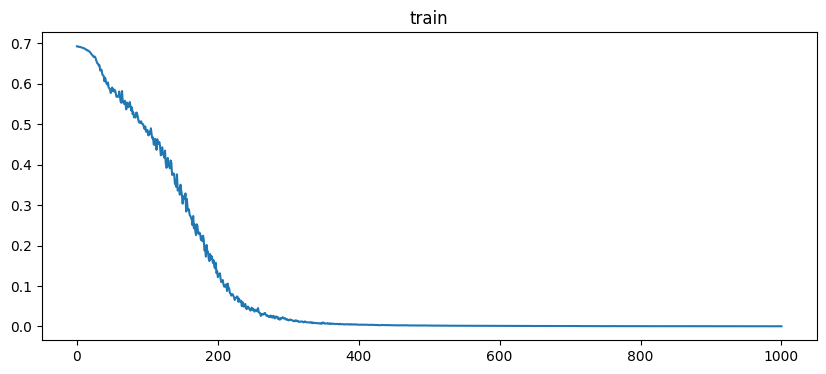

In [ ]:
n_epoch = 1000 + 1
lr=0.001
criterion = nn.CrossEntropyLoss()

model = Net(features_num)
optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9)
losses_list = []
test_losses_list = []
log_interval = 100

start = time.time()
for epoch in range(n_epoch):
    running_loss = 0
    test_loss = 0
    for features, target in train_loader:
        optimizer.zero_grad()
        output = model.forward(features)
        loss = criterion(output, target.long())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses = running_loss/len(train_loader)
    losses_list.append(losses)

    true_list, pred_list = [], []
    model.eval()
    for features, target in test_loader:
        output = model.forward(features)
        loss = criterion(output, target.long())
        test_loss += loss.item()
        _, pred = torch.max(output, 1)
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()
    losses_ = test_loss/len(test_loader)
    test_losses_list.append(losses_)
    if epoch % log_interval == 0:
        print("Epoch: {:4}/{} |".format(epoch, n_epoch-1),
              "{:9} |".format(time_since(start)),
              "Training loss: {:.3f}.. |".format(losses),
              "(test) accuracy => {:.2f} |".format(accuracy_score(true_list, pred_list)),
              "(test) f1-score => {:.2f}".format(f1_score(true_list, pred_list)))

print('Finished Training')

fig, axs = plt.subplots(figsize=(10, 4))
axs.plot(range(len(losses_list)), losses_list)
axs.set_title("train")

In [ ]:
model.eval()
test_loss = []
correct = 0
true_list = []
pred_list = []
with torch.no_grad():
    for features, target in test_loader:
        output = model(features)
        test_loss.append(criterion(output, target.long()))
        _, pred = torch.max(output, 1)
        true_list += target.numpy().tolist()
        pred_list += np.squeeze(pred.numpy()).tolist()


print('accuracy_score ', accuracy_score(true_list, pred_list))
print('f1_score ', f1_score(true_list, pred_list))
print('precision_score ', precision_score(true_list, pred_list))
print('recall_score ', recall_score(true_list, pred_list))

print(f'Avg. loss: {np.mean(test_loss):.4f}')

accuracy_score  0.939297124600639
f1_score  0.8041237113402061
precision_score  0.8348623853211009
recall_score  0.7755681818181818
Avg. loss: 0.5887
